# Training Notebook for COMP9993 Thesis.

## Skeletal-Based Body Gesture Interaction With A Social Robot Companion

Written by Hongliang Sun.

#### Data Exploration, Cleanup, and Validation

We have five main classes, each of which has 50 data samples. Each data sample has 10 txt files which denote frames in time of the classes' gesture. 

In [ ]:
import os


def countFoldersRecursively(folder_path, level=0):
    # Get the folder name from the path
    folder_name = os.path.basename(folder_path)

    # Count the number of subfolders and .txt files in the current folder
    subfolders = next(os.walk(folder_path))[1]  # List of subdirectories
    files = [
        f for f in os.listdir(folder_path) if f.endswith(".txt")
    ]

    # Print the current folder name, subfolder count, and .txt file count
    indent = " " * (level * 4)
    print(f"{indent}{folder_name}/")
    print(f"{indent}  Subfolders: {len(subfolders)}, .txt Files: {len(files)}")

    # Recursively traverse each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        countFoldersRecursively(subfolder_path, level + 1)

dataPath = "./3d_dataset"
countFoldersRecursively(dataPath)

To ensure that each file has the exact same number of datapoints so there are no inconsistencies, we will check it with the following script.

In [2]:
# This function ensures that all .txt files in the dataset have the correct number of lines (78 lines)
def checkFileLineCount(folder_path, required_lines=78):
    files_with_wrong_lines = []  # To store files that don't meet the line count

    # Recursively go through all subfolders and check each file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    # Now check and store the actual line count for this file
                    if len(lines) != required_lines:
                        files_with_wrong_lines.append((file_path, len(lines)))

    # Output the result
    if not files_with_wrong_lines:
        print("-- All Files Meet the Required Line Count --")
    else:
        print("The following files do not have the required number of lines:")
        print(f"There are {len(files_with_wrong_lines)} files with wrong line count")
        print(f"-- Required: {required_lines} lines per file--")
        for file_path, line_count in files_with_wrong_lines:
            print(f"{file_path} has {line_count} lines (Expected: {required_lines})")


dataPath = "./3d_dataset"
checkFileLineCount(dataPath)

-- All Files Meet the Required Line Count --


In [3]:
# This function is a check on the validity of mediapipe's extracted hand labels in the dataset. 
# It checks if each file has exactly one "Left Hand:" and one "Right Hand:" label.

def checkFileLineCountAndHandLabels(folder_path):
    files_with_wrong_lines = []
    files_with_hand_label_issues = ([])  # Files with more than one left or right hand

    # Recursively go through all subfolders and check each file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    # Check for "Left Hand:" and "Right Hand:" occurrences
                    left_hand_count = sum(1 for line in lines if "Hand: Left" in line)
                    right_hand_count = sum(1 for line in lines if "Hand: Right" in line)

                    if left_hand_count != 1 or right_hand_count != 1:
                        files_with_hand_label_issues.append(
                            (file_path, left_hand_count, right_hand_count)
                        )

    if not files_with_hand_label_issues:
        print("All files contain exactly one 'Left Hand:' and one 'Right Hand:'.")
    else:
        print(f"There are {len(files_with_hand_label_issues)} files with issues:")
        print(
            "The following files have issues with 'Left Hand:' or 'Right Hand:' occurrences:"
        )
        for (
            file_path,
            left_hand_count,
            right_hand_count,
        ) in files_with_hand_label_issues:
            print(
                f"{file_path} has {left_hand_count} 'Left Hand:' and {right_hand_count} 'Right Hand:'"
            )


dataPath = "./3d_dataset"
checkFileLineCountAndHandLabels(dataPath)

All files contain exactly one 'Left Hand:' and one 'Right Hand:'.


In [ ]:
# This function will modify the dataset so Left Hand starts first, followed by Right Hand.
def swap_left_right_hand_if_needed(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Find indices where "Hand: Left", "Hand: Right", and "Body:" occur
    left_hand_start = None
    right_hand_start = None
    body_start = None

    for i, line in enumerate(lines):
        if "Hand: Left" in line:
            left_hand_start = i
        elif "Hand: Right" in line:
            right_hand_start = i
        elif "Body:" in line:
            body_start = i
            break

    # If "Hand: Right" occurs before "Hand: Left", swap the sections
    if (
        left_hand_start is not None
        and right_hand_start is not None
        and right_hand_start < left_hand_start
    ):
        # Extract Right Hand data
        right_hand_data = lines[right_hand_start : right_hand_start + 1]
        for i in range(right_hand_start + 1, len(lines)):
            if "Hand:" in lines[i] or "Body:" in lines[i]:
                break
            right_hand_data.append(lines[i])

        # Extract Left Hand data
        left_hand_data = lines[left_hand_start : left_hand_start + 1]
        for i in range(left_hand_start + 1, len(lines)):
            if "Hand:" in lines[i] or "Body:" in lines[i]:
                break
            left_hand_data.append(lines[i])

        # If body data exists, extract the body section
        body_data = lines[body_start:] if body_start else []

        # Replace the data in the correct order: Left Hand first, Right Hand second, Body at the end
        reordered_data = left_hand_data + right_hand_data + body_data

        # Write the reordered data back into the file
        with open(file_path, "w") as f:
            f.writelines(reordered_data)


def organize_files_in_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                swap_left_right_hand_if_needed(file_path)
                print(f"Processed {file_path}")


dataPath = "./3d_dataset"
organize_files_in_folder(dataPath)

Next, we will begin purging points that are of no little interest/significance in our task. This will involve the removal of landmarks, and the conversion of the remaining datapoints into tensors.

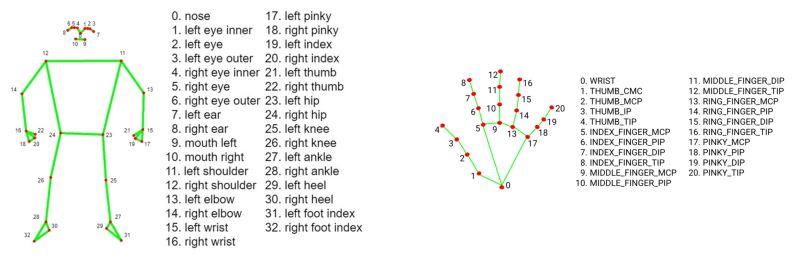

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread("./utils/body_landmarks.png")
img2 = mpimg.imread("./utils/hand_landmarks.png")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")

# Show the images
plt.show()

We will remove the following points from the following body landmarks. Refer above for corresponding part.

Body: [11 - 16 + 23 - 24]

[0 - 10] All face landmarks will be removed.
[11 - 16] Arm landmarks will be retained.
[15 - 22] All hand landmarks will be removed.
[23 - 24] Lower hip landmarks will be retained.
[25 - 32] All lower-hip landmarks will be removed.

Hand: All hand landmarks will be retained.

In [ ]:
def process_file(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Step 1: Remove "Hand: Left", "Hand: Right", and "Body" tags
    cleaned_lines = [
        line
        for line in lines
        if "Hand: Left" not in line
        and "Hand: Right" not in line
        and "Body:" not in line
    ]

    # Step 2: Split the remaining lines into hand data and body data
    hand_data = cleaned_lines[:-33]  # All lines except the last 33 belong to the hands
    body_data = cleaned_lines[-33:]  # Last 33 lines are the body data

    # Step 3: Select specific body lines (11-16, 23, and 24)
    selected_body_lines = body_data[11:17] + [body_data[23], body_data[24]]

    # Step 4: Combine hand data and selected body lines
    final_data = hand_data + selected_body_lines

    # Step 5: Write the final data back to the file
    with open(file_path, "w") as f:
        f.writelines(final_data)

    print(f"Processed file: {file_path}")


def process_files_in_directory(directory_path):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".txt"):  # Only process .txt files
                file_path = os.path.join(root, file)
                process_file(file_path)


dataset_path = "./3d_dataset"
process_files_in_directory(dataset_path)

For 2d_dataset:

1. We will remove the z axis alltogether, this is very simple and can be done without much validation

In [ ]:
# def remove_depth_from_file(file_path):
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     def remove_depth(line):
#         values = line.split(",")
#         return f"{values[0].strip()}, {values[1].strip()}\n"
#     processed_lines = [remove_depth(line) for line in lines if line.strip()]
#     with open(file_path, "w") as f:
#         f.writelines(processed_lines)
#     print(f"Processed file: {file_path}")


# def process_files_in_directory(directory_path):
#     for root, dirs, files in os.walk(directory_path):
#         for file in files:
#             if file.endswith(".txt"):  
#                 file_path = os.path.join(root, file)
#                 remove_depth_from_file(file_path)


# dataset_path = "./dataset"
# process_files_in_directory(dataset_path)

For 3d_dataset

1. This requires more sophisticated checks, first we will fix any outlier depth points back to their original (or somewhat nearby) depth.
2. We will also do manipulation that skews the depth of the image to a scale for multiple perceived depths.

In [14]:
# import numpy as np
# import os


# def find_depth_outliers(file_path, multiplier=3):
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     y_values = []
#     for line in lines:
#         values = line.split(",")
#         if len(values) >= 2:
#             try:
#                 y = float(values[1].strip())  # Use y-axis value (second in the line)
#                 y_values.append(y)
#             except ValueError:
#                 continue

#     # Calculate Q1, Q3, and IQR
#     Q1 = np.percentile(y_values, 25)
#     Q3 = np.percentile(y_values, 75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - multiplier * IQR
#     upper_bound = Q3 + multiplier * IQR

#     # Find outliers
#     outliers = []
#     for i, y in enumerate(y_values):
#         if y < lower_bound or y > upper_bound:
#             outliers.append((i, y))

#     if outliers:
#         return True, outliers
#     else:
#         return False, []


# def process_files_for_outliers(directory_path, multiplier=3):
#     outlier_files_count = 0

#     for root, dirs, files in os.walk(directory_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 has_outliers, outliers = find_depth_outliers(file_path, multiplier)
#                 if has_outliers:
#                     outlier_files_count += 1
#                     print(f"Outliers in file: {file_path}")
#                     for index, y in outliers:
#                         print(f"  Line {index + 1}: y-value = {y}")

#     # Summary message
#     if outlier_files_count > 0:
#         print(f"\nTotal files with outliers: {outlier_files_count}")
#     else:
#         print("\nNo files with outliers found.")

# dataset_path = "./3d_dataset"
# process_files_for_outliers(dataset_path)

In [ ]:
import numpy as np
import os
import random


def scale_points(points, depth_scale):
    # Convert each point's y (depth) and rescale x and z accordingly
    scaled_points = []
    for x, y, z in points:
        # Scale depth (y)
        new_y = y * depth_scale

        # Calculate scaling factor for x and z based on change in depth
        scale_ratio = new_y / y if y != 0 else 1  # Avoid division by zero
        new_x = x * scale_ratio
        new_z = z * scale_ratio

        scaled_points.append((new_x, new_y, new_z))

    return scaled_points

# Modify end_index to avoid overwriting existing folders, e.g., set to 100 to create new folders starting from 101
def apply_random_depth_scale_to_dataset(base_directory, scale_range=(0.5, 2.0), end_index=400):
    # Traverse each parent action folder in the base directory (like '1_waving')
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)

        # Ensure it's a directory
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)

                # Ensure subfolder is a digit-only folder name (like '1', '2', etc.)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    # Define new folder name and path by adding end_index to the subfolder number
                    new_subfolder_name = str(int(subfolder) + end_index)
                    new_subfolder_path = os.path.join(
                        action_folder_path, new_subfolder_name
                    )
                    os.makedirs(new_subfolder_path, exist_ok=True)

                    # Process each file in the current subfolder
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            # Parse the filename to create the new filename
                            prefix, suffix = file.split("_", 1)
                            new_filename = f"{int(prefix) + end_index}_{suffix}"
                            output_file_path = os.path.join(
                                new_subfolder_path, new_filename
                            )
                            input_file_path = os.path.join(subfolder_path, file)

                            # Apply random scaling and save to output file
                            apply_random_depth_scale(
                                input_file_path, output_file_path, scale_range
                            )


def apply_random_depth_scale(input_file_path, output_file_path, scale_range=(0.5, 2.0)):
    # Generate a random depth scale within the provided range
    depth_scale = random.uniform(*scale_range)
    print(f"Applying depth scale: {depth_scale} to {input_file_path}")

    # Read the original file and parse points
    points = []
    with open(input_file_path, "r") as f:
        for line in f:
            values = line.split(",")
            if len(values) >= 3:
                try:
                    x = float(values[0].strip())
                    y = float(values[1].strip())
                    z = float(values[2].strip())
                    points.append((x, y, z))
                except ValueError:
                    continue  # Skip lines that cannot be parsed

    # Scale points with the random depth scale
    scaled_points = scale_points(points, depth_scale)

    # Write the scaled points to a new file in the scaled folder
    with open(output_file_path, "w") as f:
        for x, y, z in scaled_points:
            f.write(f"{x}, {y}, {z}\n")

    print(f"Saved scaled points to: {output_file_path}")


# Usage example:
# Set the base directory where all parent folders are located
base_directory = "./3d_dataset"
apply_random_depth_scale_to_dataset(base_directory)

Validation that all the data has been manipulated properly we will check the expected length of all files = 50 lines.

In [28]:
checkFileLineCount("./3d_dataset", 50)

-- All Files Meet the Required Line Count --


#### Training

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import copy

from sklearn.model_selection import train_test_split

In [30]:
# Step 1: Load the data into tensors
def loadGestureData(directory_path="./dataset"):
    all_data = []
    all_labels = []

    # Iterate through all files
    for gestureFolder in sorted(os.listdir(directory_path)):
        gesturePath = os.path.join(directory_path, gestureFolder)
        if os.path.isdir(gesturePath):
            # Retrieve the label of the dataset
            label = int(gestureFolder.split("_")[0]) - 1
            # Loop through the samples inside the folder (1-50)
            for sampleFolder in sorted(os.listdir(gesturePath)):
                samplePath = os.path.join(gesturePath, sampleFolder)
                if os.path.isdir(samplePath):
                    # Loop through the .txt files inside the folder (1 - 10)
                    sample_data = []
                    for txt_file in sorted(os.listdir(samplePath)):
                        if txt_file.endswith(".txt"):
                            txt_file_path = os.path.join(samplePath, txt_file)
                            with open(txt_file_path, "r") as f:
                                lines = f.readlines()
                                # Convert the data into a tensor
                                tensor_data = torch.tensor([list(map(float, line.strip().split(","))) for line in lines])
                                sample_data.append(tensor_data)
                    sample_tensor = torch.stack(sample_data)
                    all_data.append(sample_tensor)
                    all_labels.append(label)
    return torch.stack(all_data), torch.tensor(all_labels)

dataset_path = "./3d_dataset"
data, labels = loadGestureData(dataset_path)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: torch.Size([4000, 10, 50, 3]), Labels shape: torch.Size([4000])


In [31]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: torch.Size([3200, 10, 50, 3]), Test data shape: torch.Size([800, 10, 50, 3])


In [32]:
class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(ConvLSTMModel, self).__init__()
        self.conv = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, 10, 50, 3) -> reshape for Conv1D
        batch_size, num_files, num_points, num_features = (
            x.size()
        )  # (batch_size, 10, 50, 3)
        x = x.view(batch_size * num_files, num_points, num_features).permute(
            0, 2, 1
        )  # (batch_size * 10, 3, 50)

        # Apply Conv1D
        x = self.conv(x)  # (batch_size * 10, 32, 50)
        x = x.permute(0, 2, 1)  # (batch_size * 10, 50, 32)

        # Reshape and apply LSTM
        x = x.view(batch_size, num_files, num_points, -1).mean(1)  # (batch_size, 50, 32)
        lstm_out, _ = self.lstm(x)  # (batch_size, 50, hidden_dim)

        # Take the final hidden state and pass through a fully connected layer
        final_output = self.fc(lstm_out[:, -1, :])  # (batch_size, output_dim)
        return final_output


# Define the model
input_dim = 3  # x, y, and z coordinates
hidden_dim = 64
num_layers = 2
output_dim = 5  # Number of gestures

model = ConvLSTMModel(input_dim, hidden_dim, num_layers, output_dim)

In [33]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert to TensorDataset and DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Early stopping parameters
patience = 250 
best_val_loss = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())
epochs_without_improvement = 0

# Define color codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RESET = "\033[0m"

# Function to evaluate model on the validation set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy


def train_model_with_early_stopping(model, train_loader, test_loader, max_epochs=50000):
    global best_val_loss, best_model_wts, epochs_without_improvement
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation after every epoch
        val_loss, val_accuracy = evaluate_model(model, test_loader)
        print(
            f"{YELLOW}Epoch {epoch+1}/{max_epochs}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%{RESET}"
        )

        # Check if the current validation loss is the best one
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(
                model.state_dict()
            )  # Save the best model weights
            epochs_without_improvement = 0  # Reset the counter
            print(f"{GREEN}Best model updated with validation loss: {val_loss}{RESET}")
        else:
            epochs_without_improvement += 1

        # Stop if no improvement is seen for 200 epochs
        if epochs_without_improvement >= patience:
            print(
                f"{RED}Early stopping after {epoch+1} epochs due to no improvement for {patience} epochs.{RESET}"
            )
            break

    # Load the best model weights at the end
    model.load_state_dict(best_model_wts)
    return model


# Train the model with early stopping
model = train_model_with_early_stopping(model, train_loader, test_loader)

# Save the best model to a file
torch.save(model.state_dict(), "3d_best_model.pth")
print("Best model saved to '3d_best_model.pth'")

Epoch 1/50000, Loss: 1.395634285211563, Val Loss: 1.2631086683273316, Val Accuracy: 40.625%
Best model updated with validation loss: 1.2631086683273316
Epoch 2/50000, Loss: 0.8401066827774047, Val Loss: 0.6693176603317261, Val Accuracy: 72.375%
Best model updated with validation loss: 0.6693176603317261
Epoch 3/50000, Loss: 1.4353184759616853, Val Loss: 1.162965190410614, Val Accuracy: 54.125%
Epoch 4/50000, Loss: 1.0686855697631836, Val Loss: 0.9360252332687378, Val Accuracy: 63.5%
Epoch 5/50000, Loss: 0.8344266229867935, Val Loss: 0.8385374021530151, Val Accuracy: 67.75%
Epoch 6/50000, Loss: 0.6497382709383964, Val Loss: 0.5545913088321686, Val Accuracy: 81.375%
Best model updated with validation loss: 0.5545913088321686
Epoch 7/50000, Loss: 0.4979465675354004, Val Loss: 0.5626053845882416, Val Accuracy: 76.75%
Epoch 8/50000, Loss: 0.4527501848340034, Val Loss: 0.5211026227474213, Val Accuracy: 77.5%
Best model updated with validation loss: 0.5211026227474213
Epoch 9/50000, Loss: 0.4

#### Evaluation

Classification Report:
              precision    recall  f1-score   support

      Waving       1.00      1.00      1.00       160
    ThumbsUp       1.00      1.00      1.00       160
    Pointing       1.00      1.00      1.00       160
   Shrugging       1.00      1.00      1.00       160
    ComeHere       1.00      1.00      1.00       160

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



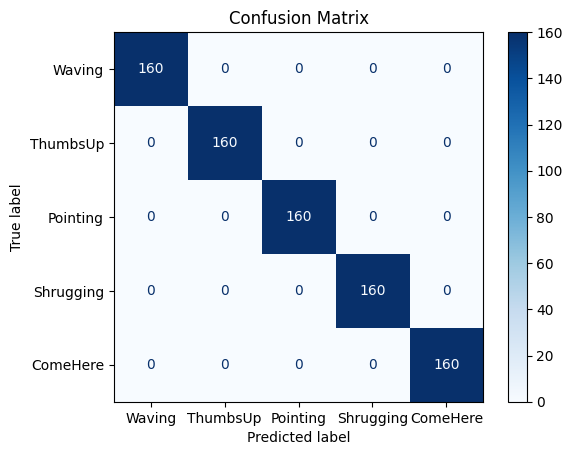

array([[160,   0,   0,   0,   0],
       [  0, 160,   0,   0,   0],
       [  0,   0, 160,   0,   0],
       [  0,   0,   0, 160,   0],
       [  0,   0,   0,   0, 160]], dtype=int64)

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


# Function to evaluate the model and compute additional metrics
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(predicted.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print classification report (precision, recall, F1-score)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return cm


# Load the best model
model.load_state_dict(torch.load("3d_best_model.pth"))
class_names = ["Waving", "ThumbsUp", "Pointing", "Shrugging", "ComeHere"]
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
evaluate_model_with_metrics(model, test_loader, class_names)